In [14]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras 
import random
from keras import backend as K
from keras.utils import plot_model, to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, Input, UpSampling1D
from keras.optimizers import SGD, RMSprop
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from prettytable import PrettyTable
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


%matplotlib inline

# Autoencoder mit komprimiertem Input (Ausgabe Bild)

In [15]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)

#inputs und targets generieren (Spalte 1 für die Targets, Spalte 2 bis Ende für die Inputs)
inputs = df.iloc[1:, 2:].values

#Standardscaler über inputs laufen lassen 
scaler = StandardScaler()
scaler.fit(inputs)
# Apply transform to Inputs
scaled_inputs = scaler.transform(inputs)

# Make an instance of the Model
pca = PCA(n_components=20) # ODER: pca = PCA(n_components=20)
pca.fit(scaled_inputs)

inputs = pca.transform(scaled_inputs)


inputs = inputs.reshape(-1,20,1).astype( 'float32' )

# Daten shuffeln
random.shuffle(inputs)

# In Training und Validierungsdaten zur Rekonstuktion splitten (10:10)
training, val = np.array_split(inputs, 2)

print('Input Shape : ' , inputs.shape)

#Trainingsdaten in test und training splitten (7:3)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(training, training, test_size = 0.3)


#(Anzahl Datenpunkte, Höhe, Breite, Kanäle)  
print('Training data shape : ', inputs_train.shape, targets_train.shape)
print('Testing data shape : ', inputs_test.shape, targets_test.shape)



Input Shape :  (20, 20, 1)
Training data shape :  (7, 20, 1) (7, 20, 1)
Testing data shape :  (3, 20, 1) (3, 20, 1)


### Plotfunktion

In [16]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [17]:
# ENCODER
input_sig = Input(batch_shape=(None,20,1))
x = Conv1D(16,2, activation='relu', padding='valid')(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(32,2, activation='relu', padding='valid')(x1)
x3 = MaxPooling1D(2)(x2)
flat = Flatten()(x3)
encoded = Dense(32,activation = 'relu')(flat)
 
print("Encoder Shape {}".format(K.int_shape(encoded)))
 
# DECODER 
x2_ = Conv1D(32, 2, activation='relu', padding='valid')(x3)
x1_ = UpSampling1D(2)(x2_)
x_ = Conv1D(32, 2, activation='relu', padding='valid')(x1_)
upsamp = UpSampling1D(2)(x_)
flat = Flatten()(upsamp)
decoded = Dense(20,activation = 'relu')(flat)
decoded = Reshape((20,1))(decoded)
 
print("Decoder Shape {}".format(K.int_shape(decoded)))
 
autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

Encoder Shape (None, 32)
Decoder Shape (None, 20, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 19, 16)            48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 9, 16)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 8, 32)             1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 3, 32)             2080      
_________________________________________________________________
up_sam

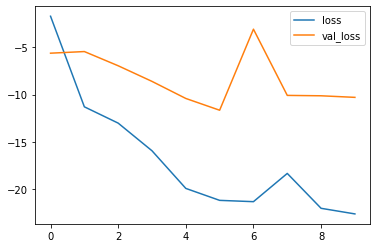

In [18]:
autoencoder_train = autoencoder.fit(inputs_train, targets_train, 
                                    batch_size=2,
                                    epochs=10,
                                    verbose=1,
                                    validation_data=(inputs_test, targets_test),
                                    callbacks=[plot_losses])


In [19]:
#Prediction
pred = autoencoder.predict(val)
pred.shape

(10, 20, 1)

## Rekonstruktion der Testmenge 

Testmenge: 


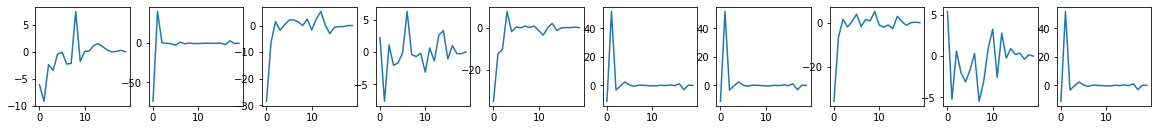

Rekonstruktion der Testmenge: 


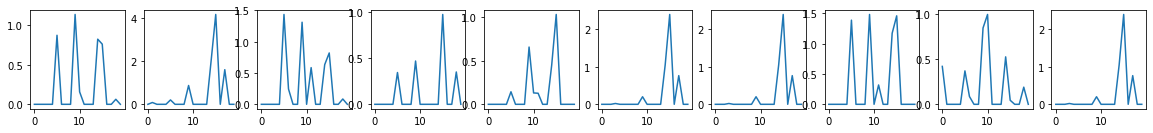

In [20]:
plt.figure(figsize=(20, 4))
print("Testmenge: ")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.plot(val[i])
plt.show()  

plt.figure(figsize=(20, 4))
print("Rekonstruktion der Testmenge: ")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.plot(pred[i]) 
plt.show()
